# **---------------TRANSFORMER MODEL FOR TIME SERIES---------------**

**Importing dataset from Github and installing a package**

In [91]:
%%capture
!git clone https://github.com/alphaameer007/RHM_FYP
!pip install torchmetrics

**Importing necessary libraries/packages**

In [92]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

**Importing data as dataframe**

In [93]:
#df=pd.read_csv('/kaggle/input/turkeywindfarm/TurkeyWindFarm.csv')
#df
train = pd.read_csv('/content/RHM_FYP/train_8020.csv')
test = pd.read_csv('/content/RHM_FYP/test_8020.csv')
print(train)
print(test)

                   time  Wind Speed (m/s)  wind energy  Wind Direction (°)  \
0       01/01/2018 0:00          5.311336   416.328908          259.994904   
1       01/01/2018 0:10          5.672167   519.917511          268.641113   
2       01/01/2018 0:20          5.216037   390.900016          272.564789   
3       01/01/2018 0:30          5.659674   516.127569          271.258087   
4       01/01/2018 0:40          5.577941   491.702972          265.674286   
...                 ...               ...          ...                 ...   
42043  10/19/2018 23:10          1.899933    39.714621           68.868103   
42044  10/19/2018 23:20          1.645516    39.299767           80.923714   
42045  10/19/2018 23:30          1.582637    38.884914          111.108299   
42046  10/19/2018 23:40          1.494098    38.470060          150.824799   
42047  10/19/2018 23:50          1.779607    38.055206          159.626099   

       LV ActivePower (kW)  
0               380.047791  
1    

# **Data Preparation (using sliding window technique)**

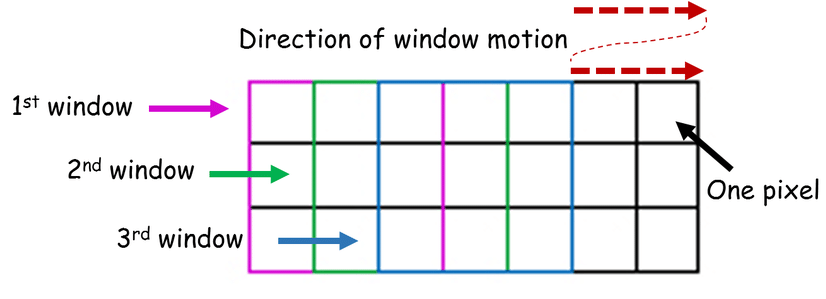

**Separate time variable**

In [94]:
time = test['time']
print(time)

0         10/20/2018 0:00
1         10/20/2018 0:10
2         10/20/2018 0:20
3         10/20/2018 0:30
4         10/20/2018 0:40
               ...       
10507    12/31/2018 23:10
10508    12/31/2018 23:20
10509    12/31/2018 23:30
10510    12/31/2018 23:40
10511    12/31/2018 23:50
Name: time, Length: 10512, dtype: object


In [95]:
train.drop('time', inplace=True, axis=1)
test.drop('time', inplace=True, axis=1)
print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42048 entries, 0 to 42047
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Wind Speed (m/s)     42048 non-null  float64
 1   wind energy          42048 non-null  float64
 2   Wind Direction (°)   42048 non-null  float64
 3   LV ActivePower (kW)  42048 non-null  float64
dtypes: float64(4)
memory usage: 1.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10512 entries, 0 to 10511
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Wind Speed (m/s)     10512 non-null  float64
 1   wind energy          10512 non-null  float64
 2   Wind Direction (°)   10512 non-null  float64
 3   LV ActivePower (kW)  10512 non-null  float64
dtypes: float64(4)
memory usage: 328.6 KB
None


**Normalizing data in between range [0,1]**

In [96]:
train_min = train.min(axis=0)
train_max = train.max(axis=0)
print(train_max)
print(train_min)

Wind Speed (m/s)         25.206011
wind energy            3600.000000
Wind Direction (°)      359.987396
LV ActivePower (kW)    3618.732910
dtype: float64
Wind Speed (m/s)        0.065332
wind energy            10.903226
Wind Direction (°)      0.015678
LV ActivePower (kW)    -2.471405
dtype: float64


In [97]:

train_min = train.min(axis=0)
train_max = train.max(axis=0)


train = (train - train_min) / ( train_max - train_min)
test = (test - train_min) / ( train_max - train_min)

print(train.head(10))
print(test.head(10))

   Wind Speed (m/s)  wind energy  Wind Direction (°)  LV ActivePower (kW)
0          0.208666     0.112960            0.722221             0.105633
1          0.223018     0.141822            0.746240             0.125991
2          0.204875     0.105875            0.757140             0.085289
3          0.222522     0.140766            0.753510             0.116568
4          0.219270     0.133961            0.737999             0.105800
5          0.220309     0.136116            0.734955             0.111804
6          0.227825     0.152258            0.739358             0.124289
7          0.208456     0.112562            0.716539             0.107620
8          0.219537     0.134511            0.704125             0.128720
9          0.217094     0.129504            0.718690             0.122113
   Wind Speed (m/s)  wind energy  Wind Direction (°)  LV ActivePower (kW)
0          0.084449     0.007450            0.535162             0.017597
1          0.066099     0.007334      

**Preparing our dataset in a sliding window fashion with a particular window size**

In [98]:
# Calculate the number of readings per day
readings_per_day = 144

#n = number of day
n = 3

# Calculate the sequence length (n days in readings)
sequence_length = readings_per_day * n

# Set the lookback window to be the same as the sequence length
lookback_window = sequence_length

# Convert the data to a NumPy array
train = train.values
test = test.values


x_train, y_train = [], []
for i in range(lookback_window, len(train)):
    x_train.append(train[i - lookback_window:i, :])
    y_train.append(train[i, -1])
x_train = np.array(x_train)
y_train = np.array(y_train)




x_test, y_test = [], []
for i in range(lookback_window, len(test)):
    x_test.append(test[i - lookback_window:i, :])
    y_test.append(test[i, -1])
x_test = np.array(x_test)
y_test = np.array(y_test)



print('x_train :',x_train.shape)
print('x_test :',x_test.shape)
print('y_train :',y_train.shape)
print('y_test :',y_test.shape)

x_train : (41616, 432, 4)
x_test : (10080, 432, 4)
y_train : (41616,)
y_test : (10080,)


# **Transformer Model**

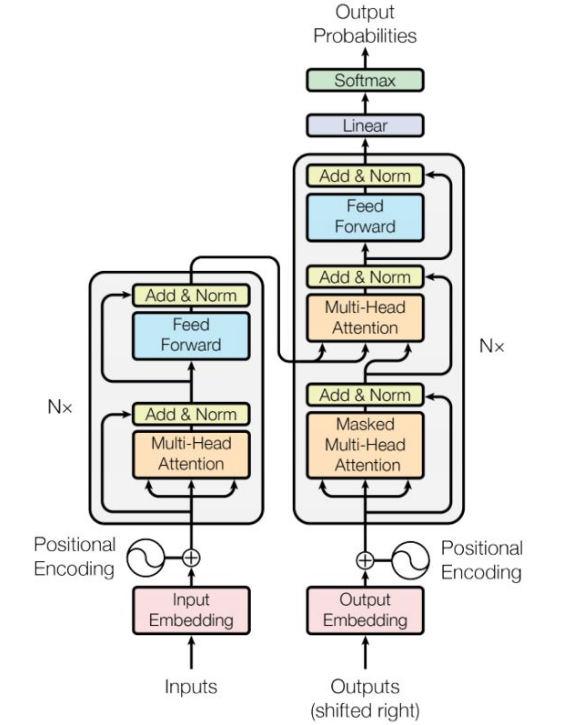

**Positional Encoding class to make transformer aware of sequencial order**

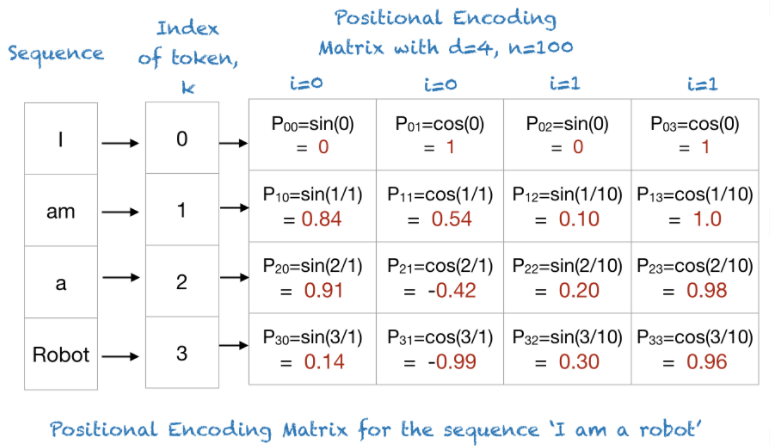

In [99]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout_p, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        position = torch.arange(max_len).unsqueeze(1)                                                           #col vector    #add another dimension from (max_len) -> (maxlen,1)
        div_term = torch.exp(torch.arange(0, embedding_size, 2).float() * (-math.log(10000.0)) / embedding_size)#row vector    #1 / 10000^(2i/embedding_size) -> div_term
        sinusoid = torch.zeros(max_len, embedding_size)                                                         # (max_len,embedding size)
        sinusoid[:, 0::2] = torch.sin(position * div_term)                                                      #col * row     # (time_step , even embedding added with sine  * div_term)
        sinusoid[:, 1::2] = torch.cos(position * div_term)                                                      # (time_step , odd embedding added with cosine * div_term)
        self.register_buffer('pos_encoding', sinusoid.unsqueeze(0))                                             #creating register buffer in pytorch graph

    def forward(self, x):
        pos_encoding = self.pos_encoding[:, :x.size(1), :]                                                      # Resize pos_encoding to match the input size of x
        x = x + pos_encoding                                                                                    #addition of positional encoding with our embedded input
        return self.dropout(x)

**Transformer Model Declaration**

In [100]:
class Transformer(nn.Module):
    def __init__(self, input_size, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, out_size, device):
        super().__init__()
        self.model_type = "Transformer"
        self.dim_model = dim_model
        self.positional_encoder = PositionalEncoding(embedding_size=dim_model, dropout_p=dropout_p, max_len=432)
        self.embedding = nn.Linear(input_size, dim_model)
        self.transformer = nn.Transformer(d_model=dim_model, nhead=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout=dropout_p)
        self.out = nn.Linear(dim_model, out_size)

    def get_tgt_mask(self, tgt_len):
        # Function to create a square attention mask for the decoder
        mask = torch.triu(torch.ones(tgt_len, tgt_len)) == 1
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)

        x = self.embedding(x) * math.sqrt(self.dim_model)
        x = self.positional_encoder(x)
        x = x.permute(1, 0, 2)  # (sequence_length, batch_size, dim_model)
        transformer_out = self.transformer(x, x, tgt_mask=self.get_tgt_mask(x.size(0)).to(device))
        out = self.out(transformer_out[-1])
        return out.squeeze()

**Initializing Transformer model by passing its parameters**

In [101]:
# Define model parameters
seq_length = lookback_window
input_size = x_train.shape[-1]
dim_model = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout_p = 0.2
out_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = Transformer(
    input_size=input_size,
    dim_model=dim_model,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dropout_p=dropout_p,
    out_size=out_size,
    device = device
)


In [102]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

Transformer(
  (positional_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (embedding): Linear(in_features=4, out_features=512, bias=True)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout2): Dropout(p=0.2, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=Tru

**Converting to tensors while also mounting them on the same device as the model**

In [103]:
# Convert data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

**Training the model after declaring optimizer, loss, metric and no. epochs**

In [104]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
#count_parameters(model)

Transformer model have 22,074,369 million trainable parameters.

In [105]:
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
# Define loss function and optimizer
criterion_1 = nn.MSELoss()                                          # MSE
criterion_2 = nn.L1Loss()                                           # MAE (L1)
criterion_3 = MeanAbsoluteError().to(device)                        # MAE
metricc = MeanAbsolutePercentageError().to(device)                  # MAPE metric
optimizer = optim.Adam(model.parameters(), lr=1e-4)                 # Adam

lossInfo = []
metricInfo = []

# Create the PyTorch DataLoader
batch_size = 128
train_loader = DataLoader(dataset=TensorDataset(x_train_tensor, y_train_tensor),
                          batch_size=batch_size, shuffle=True)

# Training parameters
num_epochs = 2

# Check if model weights exist
weights_folder = "/kaggle/working/RHM_FYP/TransformerWeights/"
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
model_file = os.path.join(weights_folder, "model_weights.pth")
epoch_file = os.path.join(weights_folder, "epoch_counter.pth")
loss_file = os.path.join(weights_folder, "LossInfo.txt")
metric_file = os.path.join(weights_folder, "MetricInfo.txt")
if os.path.exists(model_file) and os.path.exists(epoch_file):
    # Load weights and epoch counter
    model.load_state_dict(torch.load(model_file))
    epoch_counter = torch.load(epoch_file)
    print(f"Resuming training from epoch {epoch_counter}")
else:
    epoch_counter = 0
    print("Starting training from scratch")

# Train the model on GPU
for epoch in range(num_epochs):

    # Initialize the running loss and metric for the epoch
    running_loss = 0.0
    running_metric = 0.0

    # Loop over the batches in the data loader
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}", bar_format='{desc}: {percentage:3.0f}%|{bar:50}{r_bar}'):
        # Move the data and target to the GPU
        data, target = data.to(device), target.to(device)



        # Forward pass
        with torch.autocast(device_type= 'cuda', dtype=torch.float16, enabled=use_amp):
            output = model(data)
            loss = criterion_3(output.view(-1), target)
            metric_val = metricc(output.view(-1), target)

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Reset the optimizer gradients
        optimizer.zero_grad(set_to_none=True)

        # Update the running loss and metric for the epoch
        running_loss += loss.item()
        running_metric += metric_val.item()

    # Calculate the average loss and metric for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_metric = running_metric / len(train_loader)
    lossInfo.append(epoch_loss)
    metricInfo.append(epoch_metric)
    print("-"*25, f"Epoch {epoch + 1}","-"*25)
    print(f"Epoch {epoch+1} MAE loss: {epoch_loss:.9f}")
    print(f"Epoch {epoch+1} MAPE metric: {epoch_metric:.9f}")

    # Save model weights and epoch counter
    torch.save(model.state_dict(), model_file)
    torch.save(epoch+1, epoch_file)

    # Save loss and metric information
    if not os.path.exists(loss_file):
        with open(loss_file,'x') as file:
            file.write(str(lossInfo))
    else:
        with open(loss_file,"w") as file:
            file.write(str(lossInfo))

    if not os.path.exists(metric_file):
        with open(metric_file,'x') as file:
            file.write(str(metricInfo))
    else:
        with open(metric_file,"w") as file:
            file.write(str(metricInfo))

print("Training completed!")

Resuming training from epoch 2


Epoch 1: 100%|██████████████████████████████████████████████████| 326/326 [05:04<00:00,  1.07it/s]


------------------------- Epoch 1 -------------------------
Epoch 1 MAE loss: 0.056604672
Epoch 1 MAPE metric: 2.490849746


Epoch 2: 100%|██████████████████████████████████████████████████| 326/326 [05:03<00:00,  1.08it/s]


------------------------- Epoch 2 -------------------------
Epoch 2 MAE loss: 0.052240845
Epoch 2 MAPE metric: 2.278392222
Training completed!


**Downloading the weights of the model**

Or
```
!zip -r folder_name.zip folder_name/
```

In [106]:
!zip -r /kaggle/working/TransformerWeights.zip /kaggle/working/RHM_FYP/TransformerWeights

updating: kaggle/working/RHM_FYP/TransformerWeights/ (stored 0%)
updating: kaggle/working/RHM_FYP/TransformerWeights/MetricInfo.txt (stored 0%)
updating: kaggle/working/RHM_FYP/TransformerWeights/epoch_counter.pth (deflated 63%)
updating: kaggle/working/RHM_FYP/TransformerWeights/model_weights.pth (deflated 8%)
updating: kaggle/working/RHM_FYP/TransformerWeights/LossInfo.txt (stored 0%)


In [107]:
import os
os.chdir(r'/kaggle/working')

from IPython.display import FileLink

FileLink(r'TransformerWeights.zip') #click on the generated link to download model weights ;)

/kaggle/working/TransformerWeights.zip

**Plotting the loss and metric trend throughout the training of model**

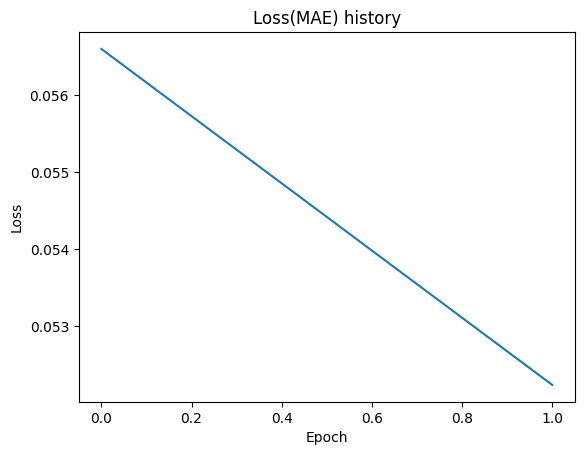

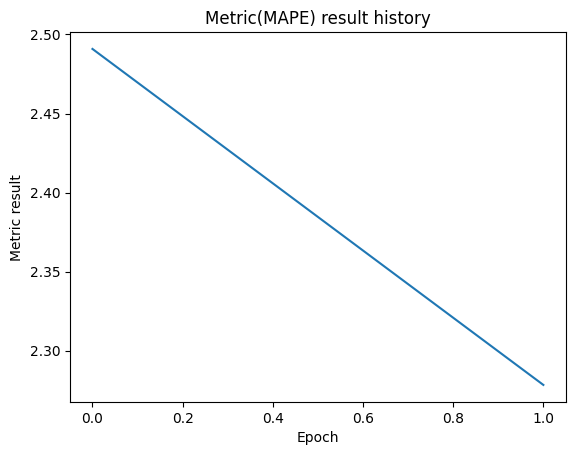

In [108]:
with open(loss_file, 'r') as file:
    temp = file.read()
lossInfo = list(eval(temp))
# Plot the history of loss
plt.plot(range(num_epochs), lossInfo)
plt.title('Loss(MAE) history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

with open(metric_file, 'r') as file:
    temp = file.read()
metricInfo = list(eval(temp))
# Plot the history of metric result
plt.plot(range(num_epochs), metricInfo)
plt.title('Metric(MAPE) result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

**Testing model performance on testset**

In [109]:
model.load_state_dict(torch.load('/kaggle/working/RHM_FYP/TransformerWeights/model_weights.pth'))

<All keys matched successfully>

In [110]:
# Convert test data to tensor
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [111]:
batch_size = 1
modPred = []
GroundTruth = []

In [112]:
running_loss = 0.0                                             # MAE Loss
running_metric = 0.0                                           # MAPE metric
for i in tqdm(range(0, len(x_test_tensor), batch_size), desc=f"Train set inference ..."): # change 50 to len(x_test_tensor)
        # Get batch of inputs and targets
        batch_x = x_test_tensor[i:i+batch_size]
        batch_y = y_test_tensor[i:i+batch_size]

        # Reshape input tensor
        batch_x = batch_x.view(-1, seq_length, input_size)

        # Forward pass
        with torch.inference_mode():
            outputs = model(batch_x)
        #print(outputs.view(-1).shape)
        modPred.append(outputs.view(-1).cpu().detach())
        GroundTruth.append(batch_y.cpu().detach())
        loss = criterion_3(outputs.view(-1), batch_y)
        metric = metricc(outputs.view(-1), batch_y)
        running_loss += loss.item()
        running_metric += metric.item()

test_loss = running_loss / (len(x_train) / batch_size)
test_metric = running_metric / (len(x_train) / batch_size)
print("-"*25, "TEST LOSS", "-"*25)
print(f"Test MAE loss: {test_loss:.9f}")
print(f"Test MAPE metric: {test_metric:.9f}")

Train set inference ...: 100%|██████████| 10080/10080 [02:03<00:00, 81.54it/s]

------------------------- TEST LOSS -------------------------
Test MAE loss: 0.012583822
Test MAPE metric: 0.280051528


**Plotting the prediction of transformer on test with the ground truth**

In [113]:
p = modPred
predictions = np.array(p)


<ipython-input-113-039f13280823>:2: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  predictions = np.array(p)
<ipython-input-113-039f13280823>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  predictions = np.array(p)


Text(0.5, 1.0, 'Last 5 days of data')

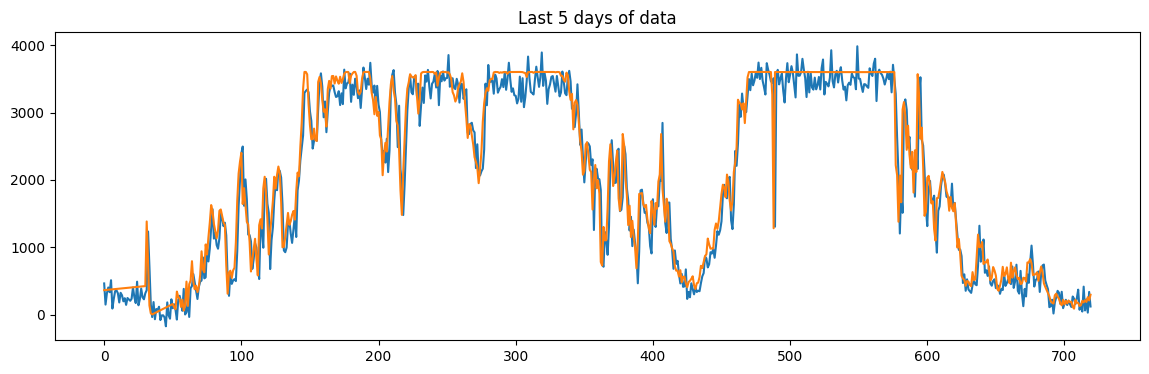

In [114]:
plt.figure(figsize=(14, 4))
predicted_d = ( (predictions * (train_max[3]-train_min[3])) + train_min[3] )
y_test_d =  ( (y_test * (train_max[3]- train_min[3])) + train_min[3] )
plt.plot(predicted_d[8496:9216])
plt.plot(y_test_d[8496:9216])
plt.title('Last 5 days of data')


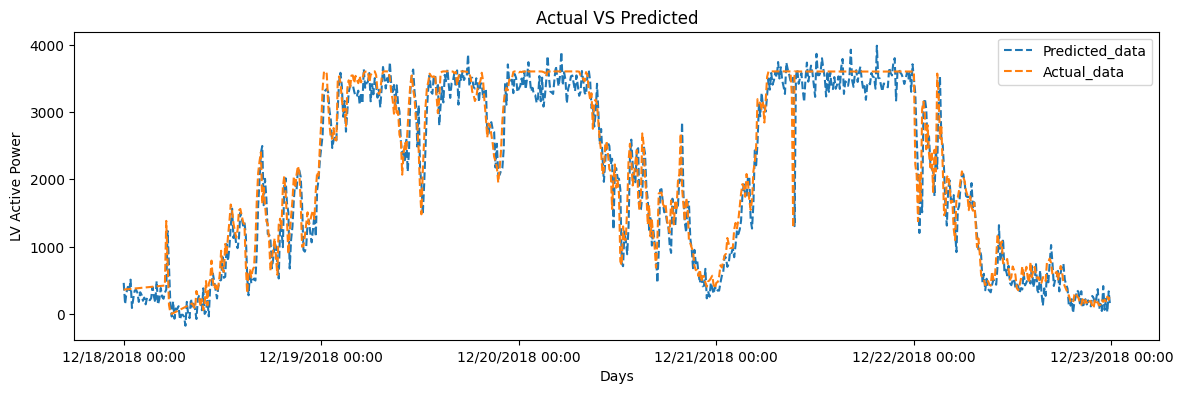

In [115]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta


x = time[8496:9216]
y1 = predicted_d[8496:9216]
y2 = y_test_d[8496:9216]
# Convert time strings to datetime objects
x = [datetime.strptime(t, '%m/%d/%Y %H:%M') for t in x]



# Create a figure and axis
fig, ax = plt.subplots(figsize=(14,4))

# Plot the data
#ax.plot(x, y1, linestyle='--')
ax.plot(x, y1, linestyle='--', label='Predicted_data')
ax.plot(x, y2, linestyle='--', label='Actual_data')


# Set x-axis formatter
date_fmt = mdates.DateFormatter('%m/%d/%Y %H:%M')
ax.xaxis.set_major_formatter(date_fmt)

# Set the x-axis interval
interval = 144

ax.set_xlabel('Days')
ax.set_ylabel('LV Active Power')
ax.set_title('Actual VS Predicted')

# Add a legend
ax.legend()

# Display the plot
plt.show()

In [116]:
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error as mae

y1 = pd.DataFrame(y1).astype("float")
time_index = pd.DataFrame(x)
predicted_data_a = pd.DataFrame(y1)
actual_data = pd.DataFrame(y2)

result = pd.concat([actual_data,predicted_data_a],axis=1)
result.columns = ['actual_data','predicted_data']

error_mape = mape(result['actual_data'],result['predicted_data'])
error_mae = mae(result['actual_data'],result['predicted_data'])



print("Mean absolute percentage error : " + str(error_mape))
print("Mean absolute  error : " + str(error_mae))
result

Mean absolute percentage error : 0.24478437412767656
Mean absolute  error : 214.4729271309204


,actual_data,predicted_data
0,365.004004,464.477173
1,367.005721,150.838287
2,369.007438,319.485260
3,371.009155,404.771179
4,373.010871,334.151398
...,...,...
715,215.484207,63.640007
716,190.253998,227.760742
717,261.101013,31.481464
718,212.121506,338.651642


In [117]:
APE = []

# Iterate over the list values
for day in range(720):

    # Calculate percentage error
    per_err = (result['actual_data'][day] - result['predicted_data'][day]) / 1500

    # Take absolute value of
    # the percentage error (APE)
    per_err = abs(per_err)

    # Append it to the APE list
    APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE   : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE   : 0.14
MAPE % : 14.3 %



In [118]:
accuracy = np.corrcoef(result['actual_data'],result['predicted_data'])
accuracy

array([[1.        , 0.97356199],
       [0.97356199, 1.        ]])